## Incidents Responded to by Fire Companies
Web url: https://data.cityofnewyork.us/Public-Safety/Incidents-Responded-to-by-Fire-Companies/tm6d-hbzd
**National Fire Incident Reporting System (NFIRS)** contains information like the kind of incident responded to, where it occurred, the resources used to mitigate it. *Goal is to understand the nature and causes of fire, as well as civilian fire casualties and firefighter injuries, and has been expanded to collect basic information on all incidents to which fire units respond.*

In [3]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
from sklearn import linear_model
from sklearn.metrics import r2_score
import datetime
plt.style.use('ggplot')

In [4]:
data=pd.read_csv("Incidents_Responded_to_by_Fire_Companies.csv")
print(len(data))

C:\Users\Sangy\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2698: DtypeWarning: Columns (1,14) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


2277779


In [5]:
data.head()

,IM_INCIDENT_KEY,FIRE_BOX,INCIDENT_TYPE_DESC,INCIDENT_DATE_TIME,ARRIVAL_DATE_TIME,UNITS_ONSCENE,LAST_UNIT_CLEARED_DATE_TIME,HIGHEST_LEVEL_DESC,TOTAL_INCIDENT_DURATION,ACTION_TAKEN1_DESC,...,ZIP_CODE,BOROUGH_DESC,FLOOR,CO_DETECTOR_PRESENT_DESC,FIRE_ORIGIN_BELOW_GRADE_FLAG,STORY_FIRE_ORIGIN_COUNT,FIRE_SPREAD_DESC,DETECTOR_PRESENCE_DESC,AES_PRESENCE_DESC,STANDPIPE_SYS_PRESENT_FLAG
0,55672688,2147,"300 - Rescue, EMS incident, other",01/01/2013 12:00:20 AM,01/01/2013 12:14:23 AM,1.0,01/01/2013 12:20:06 AM,"1 - More than initial alarm, less than Signal 7-5",1186.0,"00 - Action taken, other",...,10454,2 - Bronx,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,55672692,818,735A - Unwarranted alarm/defective condition o...,01/01/2013 12:00:37 AM,01/01/2013 12:09:03 AM,3.0,01/01/2013 12:30:06 AM,"1 - More than initial alarm, less than Signal 7-5",1769.0,86 - Investigate,...,10036,1 - Manhattan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,55672693,9656,"300 - Rescue, EMS incident, other",01/01/2013 12:01:17 AM,01/01/2013 12:04:55 AM,1.0,01/01/2013 12:15:18 AM,"1 - More than initial alarm, less than Signal 7-5",841.0,"00 - Action taken, other",...,11418,5 - Queens,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,55672695,7412,412 - Gas leak (natural gas or LPG),01/01/2013 12:02:32 AM,01/01/2013 12:07:48 AM,4.0,01/01/2013 12:40:11 AM,"1 - More than initial alarm, less than Signal 7-5",2259.0,44 - Hazardous materials leak control & contai...,...,11103,5 - Queens,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,55672697,4019,735A - Unwarranted alarm/defective condition o...,01/01/2013 12:01:49 AM,01/01/2013 12:06:27 AM,6.0,01/01/2013 12:24:56 AM,"1 - More than initial alarm, less than Signal 7-5",1387.0,86 - Investigate,...,11385,5 - Queens,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### What proportion of FDNY responses in this dataset correspond to the most common type of incident?

In [6]:
most_common_incident=data['INCIDENT_TYPE_DESC'].value_counts().max()
fraction_mostcommonincident=most_common_incident/len(data)
print(most_common_incident,len(data),fraction_mostcommonincident)

823378 2277779 0.361482830424


#### How many times more likely is an incident in Staten Island a false call compared to in Manhattan? The answer should be the ratio of Staten Island false call rate to Manhattan false call rate. A false call is an incident for which 'INCIDENT_TYPE_DESC' is '710 - Malicious, mischievous false call, other'.

In [7]:
#print type of incidents
#set(list(data['INCIDENT_TYPE_DESC']))
#fasle_Calls_df=data[data['INCIDENT_TYPE_DESC'].str.contains('False',case=False)==True]

#Staten Island false call rate
statenisland_df=data[data['BOROUGH_DESC'].str.contains('Staten')]
staten_falsecalls=(len(statenisland_df[statenisland_df['INCIDENT_TYPE_DESC'].str.contains('710 - Malicious, mischievous false call, other')]))
staten_total=(len(statenisland_df))
staten_falsecall_rate=staten_falsecalls/staten_total

#Manhattan false call rate
manhattan_df=data[data['BOROUGH_DESC'].str.contains('Manhattan')]
manhattan_falsecalls=(len(manhattan_df[manhattan_df['INCIDENT_TYPE_DESC'].str.contains('710 - Malicious, mischievous false call, other')]))
manhattan_total=(len(manhattan_df))
manhattan_falsecall_rate=manhattan_falsecalls/manhattan_total

print(staten_falsecall_rate/manhattan_falsecall_rate)

1.6243819471953407


#### We can use the FDNY dataset to investigate at what time of the day people cook most. Compute what proportion of all incidents are cooking fires for every hour of the day by normalizing the number of cooking fires in a given hour by the total number of incidents that occured in that hour. Find the hour of the day that has the highest proportion of cooking fires and submit that proportion of cooking fires. A cooking fire is an incident for which 'INCIDENT_TYPE_DESC' is '113 - Cooking fire, confined to container'. Note: round incident times down. For example, if an incident occured at 22:55 it occured in hour 22.

In [8]:
#convert incident date-time to datetime format as a new column
data['formatted_incident_time']=pd.to_datetime(data['INCIDENT_DATE_TIME'])

In [9]:
#add new column for just hour
data['incident_hour']=data['formatted_incident_time'].dt.hour

In [10]:
cookingfire_df=data[data['INCIDENT_TYPE_DESC'].str.contains('113 - Cooking fire, confined to container',case=False)==True]
cookingfire_df.head()

,IM_INCIDENT_KEY,FIRE_BOX,INCIDENT_TYPE_DESC,INCIDENT_DATE_TIME,ARRIVAL_DATE_TIME,UNITS_ONSCENE,LAST_UNIT_CLEARED_DATE_TIME,HIGHEST_LEVEL_DESC,TOTAL_INCIDENT_DURATION,ACTION_TAKEN1_DESC,...,FLOOR,CO_DETECTOR_PRESENT_DESC,FIRE_ORIGIN_BELOW_GRADE_FLAG,STORY_FIRE_ORIGIN_COUNT,FIRE_SPREAD_DESC,DETECTOR_PRESENCE_DESC,AES_PRESENCE_DESC,STANDPIPE_SYS_PRESENT_FLAG,formatted_incident_time,incident_hour
53,55672876,1380,"113 - Cooking fire, confined to container",01/01/2013 12:34:10 AM,01/01/2013 12:37:52 AM,3.0,01/01/2013 12:49:43 AM,"1 - More than initial alarm, less than Signal 7-5",933.0,11 - Extinguishment by fire service personnel,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2013-01-01 00:34:10,0
58,55672892,1201,"113 - Cooking fire, confined to container",01/01/2013 12:38:51 AM,01/01/2013 12:42:40 AM,6.0,01/01/2013 12:57:58 AM,"1 - More than initial alarm, less than Signal 7-5",1147.0,11 - Extinguishment by fire service personnel,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2013-01-01 00:38:51,0
120,55673073,2538,"113 - Cooking fire, confined to container",01/01/2013 01:23:26 AM,01/01/2013 01:27:05 AM,5.0,01/01/2013 01:37:33 AM,"1 - More than initial alarm, less than Signal 7-5",847.0,11 - Extinguishment by fire service personnel,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2013-01-01 01:23:26,1
248,55673417,688,"113 - Cooking fire, confined to container",01/01/2013 03:00:44 AM,01/01/2013 03:06:52 AM,5.0,01/01/2013 03:13:50 AM,"1 - More than initial alarm, less than Signal 7-5",786.0,11 - Extinguishment by fire service personnel,...,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2013-01-01 03:00:44,3
329,55673603,574,"113 - Cooking fire, confined to container",01/01/2013 04:16:58 AM,01/01/2013 04:20:21 AM,5.0,01/01/2013 04:34:42 AM,"1 - More than initial alarm, less than Signal 7-5",1064.0,11 - Extinguishment by fire service personnel,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2013-01-01 04:16:58,4


In [11]:
total_incident_hourly_list=np.array(data['incident_hour'].value_counts())
cooking_incident_hourly_list=np.array(cookingfire_df['incident_hour'].value_counts())
ratio=(cooking_incident_hourly_list/total_incident_hourly_list)

#lets find the proportion of total incidents which were cooking fire related
max_proportion=max(ratio)
hour_of_day_with_max_cooking=list(ratio).index(max_proportion)
print(max_proportion,hour_of_day_with_max_cooking)

#probably fell asleep?

0.0503179947624 2


In [139]:
cooking_incident_hourly_list=np.array(cookingfire_df['incident_hour'].value_counts())


C:\Users\Sangy\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


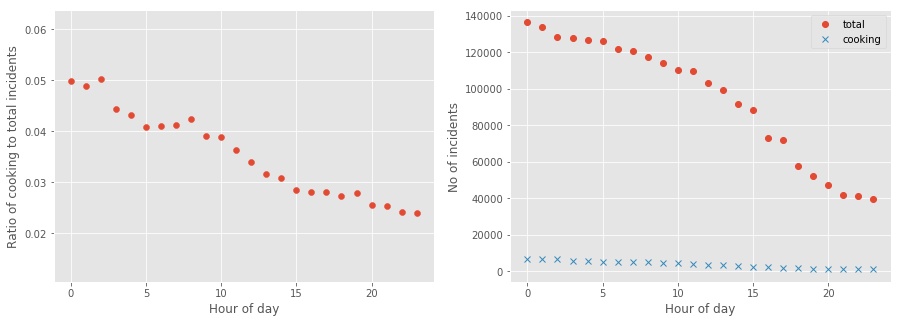

In [13]:
plt.figure(figsize=(15,5))
plt.subplot(121)
plt.scatter(range(len(ratio)),ratio)
plt.xlabel('Hour of day')
plt.ylabel('Ratio of cooking to total incidents')
plt.legend()
plt.subplot(122)
plt.plot(range(len(total_incident_hourly_list)),total_incident_hourly_list,'o',label='total')
plt.plot(range(len(cooking_incident_hourly_list)),cooking_incident_hourly_list,'x',label='cooking')
plt.xlabel('Hour of day')
plt.ylabel('No of incidents')
plt.legend()
plt.show()

#### For this question, only consider incidents that have information about whether a CO detector was present or not. We are interested in how many times more likely it is that an incident is long when CO detector is absent compared to when a CO detector is present. For events with CO detector and for those without one, compute the proportion of incidents that lasted 20-30, 30-40, 40-50, 50-60, and 60-70 minutes (both interval boundary values included) by dividing the number of incidents in each time interval with the total number of incidents. For each bin, compute the ratio of the 'CO detector absent' frequency to the 'CO detector present' frequency. Perform a linear regression of this ratio to the mid-point of the bins. From this, what is the predicted ratio for events lasting 39 minutes?

In [70]:
#make smaller dataframe with only the relevant columns
#COdetector_data=data['CO_DETECTOR_PRESENT_DESC'].dropna(how='all')
COdetector_data=data[['INCIDENT_TYPE_DESC','TOTAL_INCIDENT_DURATION','CO_DETECTOR_PRESENT_DESC']]
COdetector_data.dropna(inplace=True)
COdetector_data['CO_DETECTOR_PRESENT_DESC'].value_counts()

C:\Users\Sangy\Anaconda3\lib\site-packages\ipykernel\__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Yes    24031
No      5644
Name: CO_DETECTOR_PRESENT_DESC, dtype: int64

In [72]:
len(COdetector_data)

29675

In [93]:
#more events when CO detector is present comapred to absent
CO_present_df=COdetector_data[COdetector_data['CO_DETECTOR_PRESENT_DESC']=='Yes']
CO_absent_df=COdetector_data[COdetector_data['CO_DETECTOR_PRESENT_DESC']=='No']
print(len(CO_present_df),len(CO_absent_df),len(COdetector_data))

24031 5644 29675


In [92]:
bins = [20, 30, 40, 50, 60,70]
CO_present_bins = CO_present_df.groupby([pd.cut(CO_present_df.TOTAL_INCIDENT_DURATION/60, bins, right=True, include_lowest=True)])
CO_absent_bins = CO_absent_df.groupby([pd.cut(CO_absent_df.TOTAL_INCIDENT_DURATION/60, bins, right=True, include_lowest=True)])
print("CO present durations (minutes)",CO_present_bins.size())
print("CO absent durations (minutes)",CO_absent_bins.size())

CO present durations (minutes) TOTAL_INCIDENT_DURATION
(19.999, 30.0]    6501
(30.0, 40.0]      2145
(40.0, 50.0]       923
(50.0, 60.0]       481
(60.0, 70.0]       235
dtype: int64
CO absent durations (minutes) TOTAL_INCIDENT_DURATION
(19.999, 30.0]    1181
(30.0, 40.0]       586
(40.0, 50.0]       348
(50.0, 60.0]       249
(60.0, 70.0]       158
dtype: int64


In [96]:
#we have to normalize the frequency to total incidents with and withough CO detector to enable a comparison
CO_present_freq=np.array(CO_present_bins.size()[:])/len(CO_present_df)
CO_absent_freq=np.array(CO_absent_bins.size()[:])/len(CO_absent_df)
print(CO_present_freq)
print(CO_absent_freq)
print('ratio of the ''CO detector absent'' frequency to the ''CO detector present'' frequency: ',CO_absent_freq/CO_present_freq)

[ 0.27052557  0.08925971  0.03840872  0.02001581  0.00977904]
[ 0.20924876  0.10382707  0.0616584   0.04411765  0.02799433]
ratio of the CO detector absent frequency to the CO detector present frequency:  [ 0.77348976  1.16320205  1.60532283  2.20413966  2.8626883 ]


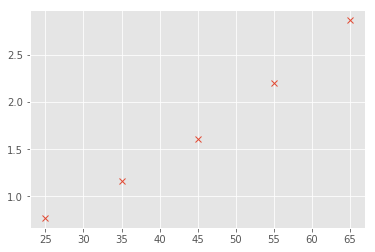

In [97]:
#incidents are longer when CO is present compared to when CO is absent
X=np.array([25,35,45,55,65])
y=CO_absent_freq/CO_present_freq
plt.plot(X,y,'x')
plt.show()

In [99]:
X=X.reshape(-1, 1)
reg = linear_model.LinearRegression().fit(X, y)
print(reg.score(X, y),reg.intercept_) 
reg.predict(np.array([[39]]))

0.987306644102 -0.626932090334


array([ 1.40860844])

#### What is the ratio of the average number of units that arrive to a scene of an incident classified as '111 - Building fire' to the number that arrive for '651 - Smoke scare, odor of smoke'?

In [19]:
buildingfire_df=data[data['INCIDENT_TYPE_DESC'].str.contains('111 - Building fire')]
smokescare_df=data[data['INCIDENT_TYPE_DESC'].str.contains('651 - Smoke scare')]

bldgfire_units=buildingfire_df['UNITS_ONSCENE'].mean()
smokescare_units=smokescare_df['UNITS_ONSCENE'].mean()

print(bldgfire_units/smokescare_units)

2.7597595139775324


#### Check the distribution of the number of minutes it takes between the time a '111 - Building fire' incident has been logged into the Computer Aided Dispatch system and the time at which the first unit arrives on scene. What is the third quartile of that distribution. Note: the number of minutes can be fractional (ie, do not round).

In [20]:
buildingfire_df['formatted_arrival_time']=pd.to_datetime(buildingfire_df['ARRIVAL_DATE_TIME'])
buildingfire_df['formatted_incident_time']=pd.to_datetime(buildingfire_df['INCIDENT_DATE_TIME'])


C:\Users\Sangy\Anaconda3\lib\site-packages\ipykernel\__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
C:\Users\Sangy\Anaconda3\lib\site-packages\ipykernel\__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [21]:
buildingfire_df['time_to_arrive']=buildingfire_df['formatted_arrival_time']-buildingfire_df['formatted_incident_time']

C:\Users\Sangy\Anaconda3\lib\site-packages\ipykernel\__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [22]:
buildingfire_df['time_to_arrive']=buildingfire_df['time_to_arrive'].dt.total_seconds()
buildingfire_df.head()

C:\Users\Sangy\Anaconda3\lib\site-packages\ipykernel\__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


,IM_INCIDENT_KEY,FIRE_BOX,INCIDENT_TYPE_DESC,INCIDENT_DATE_TIME,ARRIVAL_DATE_TIME,UNITS_ONSCENE,LAST_UNIT_CLEARED_DATE_TIME,HIGHEST_LEVEL_DESC,TOTAL_INCIDENT_DURATION,ACTION_TAKEN1_DESC,...,FIRE_ORIGIN_BELOW_GRADE_FLAG,STORY_FIRE_ORIGIN_COUNT,FIRE_SPREAD_DESC,DETECTOR_PRESENCE_DESC,AES_PRESENCE_DESC,STANDPIPE_SYS_PRESENT_FLAG,formatted_incident_time,incident_hour,formatted_arrival_time,time_to_arrive
90,55672965,2595,111 - Building fire,01/01/2013 12:58:10 AM,01/01/2013 01:00:50 AM,15.0,01/01/2013 04:15:20 AM,7 - Signal 7-5,11830.0,11 - Extinguishment by fire service personnel,...,NaN,1.0,5 - Beyond building of origin,N - None present,N - None Present,0.0,2013-01-01 00:58:10,0,2013-01-01 01:00:50,160.0
198,55673299,2591,111 - Building fire,01/01/2013 02:22:56 AM,01/01/2013 02:25:23 AM,9.0,01/01/2013 07:29:44 AM,7 - Signal 7-5,18408.0,11 - Extinguishment by fire service personnel,...,NaN,4.0,3 - Confined to floor of origin,N - None present,N - None Present,0.0,2013-01-01 02:22:56,2,2013-01-01 02:25:23,147.0
439,55673870,1601,111 - Building fire,01/01/2013 06:20:49 AM,01/01/2013 06:26:13 AM,23.0,01/01/2013 10:32:28 AM,2 - 2nd alarm,15099.0,11 - Extinguishment by fire service personnel,...,NaN,6.0,4 - Confined to building of origin,N - None present,N - None Present,0.0,2013-01-01 06:20:49,6,2013-01-01 06:26:13,324.0
491,55674012,7973,111 - Building fire,01/01/2013 07:59:48 AM,01/01/2013 08:03:33 AM,6.0,01/01/2013 08:19:37 AM,"1 - More than initial alarm, less than Signal 7-5",1189.0,11 - Extinguishment by fire service personnel,...,NaN,3.0,1 - Confined to object of origin,N - None present,N - None Present,0.0,2013-01-01 07:59:48,7,2013-01-01 08:03:33,225.0
568,55674170,1726,111 - Building fire,01/01/2013 09:47:27 AM,01/01/2013 09:49:25 AM,13.0,01/01/2013 11:11:42 AM,7 - Signal 7-5,5055.0,11 - Extinguishment by fire service personnel,...,NaN,5.0,2 - Confined to room of origin,N - None present,N - None Present,0.0,2013-01-01 09:47:27,9,2013-01-01 09:49:25,118.0


In [23]:
third_quartile=buildingfire_df['time_to_arrive'].quantile(.75)#, axis=0, numeric_only=False, interpolation='linear')
print(third_quartile)

249.00000000000003


#### What is the coefficient of determination (R squared) between the number of residents at each zip code and the number of inicidents whose type is classified as '111 - Building fire' at each of those zip codes. Note: The 2010 US Census population by zip code dataset should be downloaded from here. You will need to use both the FDNY responses and the US Census dataset. Ignore zip codes that do not appear in the census table.

In [24]:
census_data=pd.read_csv('2010+Census+Population+By+Zipcode+(ZCTA).csv')
census_data.set_index('Zip Code ZCTA',inplace=True)
census_data.head()

,2010 Census Population
Zip Code ZCTA,
1001,16769
1002,29049
1003,10372
1005,5079
1007,14649


In [25]:
buildingfire_df['ZIP_CODE']=pd.to_numeric(buildingfire_df['ZIP_CODE'],downcast='integer')
zipcode_incidents=pd.DataFrame(buildingfire_df['ZIP_CODE'].value_counts())
zipcode_incidents.rename(columns={'ZIP_CODE':'no_incidents'},inplace=True)
zipcode_incidents.head()

C:\Users\Sangy\Anaconda3\lib\site-packages\ipykernel\__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


,no_incidents
11207,218
10456,204
11208,203
11221,199
11212,186


In [26]:
#join both tables using zipcode as index
zipcode_incidents=zipcode_incidents.join(census_data,how='inner')
zipcode_incidents.head()

,no_incidents,2010 Census Population
10001,83,21102
10002,114,81410
10003,82,56024
10004,8,3089
10005,5,7135


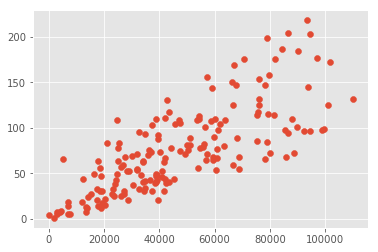

In [100]:
plt.scatter(zipcode_incidents['2010 Census Population'],zipcode_incidents['no_incidents'])
plt.show()
#coefficient_of_dermination = r2_score(zipcode_incidents['2010 Census Population'],zipcode_incidents['no_incidents'])
#print(coefficient_of_dermination)

In [101]:
from scipy import stats
slope, intercept, r_value, p_value, std_err = stats.linregress( zipcode_incidents['2010 Census Population'],zipcode_incidents['no_incidents'])
print(r_value)

0.77287734788


#### Calculate the chi-square test statistic for testing whether an incident is more likely to last longer than 60 minutes when CO detector is not present. Again only consider incidents that have information about whether a CO detector was present or not.

In [79]:
COdetector_data.head()

,INCIDENT_TYPE_DESC,TOTAL_INCIDENT_DURATION,CO_DETECTOR_PRESENT_DESC
28,"746 - Carbon monoxide detector activation, no CO",1300.0,Yes
153,736 - CO detector activation due to malfunction,398.0,Yes
194,"400 - Hazardous condition, other",1547.0,No
249,424 - Carbon monoxide incident,904.0,Yes
449,424 - Carbon monoxide incident,1871.0,Yes


In [136]:
#null hypothesis-incident is more likely when CO detector is absent
CO_all_list=COdetector_data['TOTAL_INCIDENT_DURATION'].tolist()
CO_all_list=np.array(CO_all_list)/60
CO_present=COdetector_data[COdetector_data['CO_DETECTOR_PRESENT_DESC']=='Yes']['TOTAL_INCIDENT_DURATION']
CO_present=CO_present/60
CO_present_longer_than_60min_freq=len(CO_present[CO_present>60.0])/len(CO_present)
CO_long=(np.sum(CO_present_longer_than_60min_freq))

CO_present_shorter_than_60min_freq=len(CO_present[CO_present<=60.0])/len(CO_present)
CO_short=(np.sum(CO_present_shorter_than_60min_freq))

CO_absent=COdetector_data[COdetector_data['CO_DETECTOR_PRESENT_DESC']=='No']['TOTAL_INCIDENT_DURATION']
CO_absent=CO_absent/60
CO_absent_longer_than_60min_freq=len(CO_absent[CO_absent>60.0])/len(CO_absent)
CO_absent_shorter_than_60min_freq=len(CO_absent[CO_absent<=60.0])/len(CO_absent)
noCO_long=(np.sum(CO_absent_longer_than_60min_freq))
noCO_short=(np.sum(CO_absent_shorter_than_60min_freq))

In [137]:
obs = np.array([[CO_long, CO_short], [noCO_long, noCO_short]])
chi2, p, dof, expected = stats.chi2_contingency(obs)
print (chi2,p)

4.59606380394 0.0320454500224
